### Becareful some times the code doesn't run and gurobi doesn't find a solution  because the model is unfeasible. In this case just rerun all the notebook again

With this model, we look for the position of hospitals and clinics to minimize the distance between the patient, hospitals and clinics. 
This can help us, for example, to decise where to build an hospital in the future.

* Sets\
$\text {I: The set of demand points i, }$\
$\text {K: The set of candidate locations for a level-1 PCF (e.g., clinics) k, }$\
$\text {J: The set of candidate locations for a level-2 PCF (e.g., hospitals) j, }$\
* Parameters\
$d_{ik} \text {: The travel distance (or time) between demand point i ∈ I and a level-1 PCF in candidate location k ∈ K .}$\
$d_{ik} \text {: The travel distance (or time) between a level-1 PCF in candidate location k ∈ K and a level-2 PCF in candidate location j ∈ J .}$\
$w_i \text {: The population size at demand poin i ∈ I }$\
$C_{k}^1 \text {: The capacity of the clinic k}$\
$C_{j}^2 \text {: The capacity of the hospital j}$\
$p \text {: The number of clinics to be established}$\
$q \text {: The number of hospitals to be established}$\
$\theta_k \text {: The proportion of patients in the clinic k who have to go to an hospital}$\

* Variables\
$
x_{k}^1=
\begin{cases}
1 \text{ if clinic } k \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$
x_{j}^2=
\begin{cases}
1 \text{ if hospital } j \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$u_{ik} \text {: The flow of patients between demand point i and the clinic k (e.g. flow of arc going from node i to node k)}$\
$v_{kj} \text {: The flow of patients from the clinic k who have to ho to the hospital j (e.g. flow of arc going from node k to node j)}$

* Objective function
$$
% peut etre mettre des indices genre de 1 à n
\min  \sum_{i \in I}^n \sum_{k \in K} d_{ik}* u_{ik} + \sum_{k \in K}^n \sum_{j \in J} d_{kj}* v_{kj}
$$

* Constraints\
  finir les constraintes
* type de contraintes ?
$$
\sum_{k \in K} u_{ik} = w_i \text{  } \forall i \in I
$$
* Flow balance constraints.
$$
\sum_{j \in J} v_{kj} = \theta_k  \sum_{i \in I} u_{ik} \text{  } \forall k \in K
$$
* Activation constraints
$$
0 \leq x_{ij} \leq u_{ij}*y_{ij} \forall i, j \in N
$$

In [1741]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb

%matplotlib inline

In [1742]:
#Drawing function

def DrawInitG(G, figure_size, withedges=False):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]
    
    
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6,\
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'dist').get('dist') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, figure_size, x):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]

    # fontsize=8,
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6, \
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    
    nx.draw_networkx_edges(G,pos=pos, edgelist = x, alpha=1.0)
    
        
    
    plt.axis('off')
    plt.show()

In [1743]:
graph_size = 20

In [1744]:
# Setting the network values (1)

number_of_clinic = 15
number_of_hospitals = 15
number_of_demand_points = 100

K = range(0, number_of_clinic)
J = range(number_of_clinic, number_of_clinic + number_of_hospitals)
I = range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points)

area_size = 20
# for Nantes area_size = 20
# p = 5
# q = 5
# nombre_habitant = 300 000
# Number of candidate clinic's to be established
p = 5
# Number of candidate hospital's to be established
q = 5

# Portion of patient in a clinic k referred to an hospital 
theta = {k:round(random.random(),2) for k in K}

In [1745]:
theta

{0: 0.64,
 1: 0.03,
 2: 0.33,
 3: 0.78,
 4: 0.07,
 5: 0.58,
 6: 0.48,
 7: 0.12,
 8: 0.79,
 9: 0.37,
 10: 0.21,
 11: 0.31,
 12: 0.74,
 13: 0.33,
 14: 0.23}

In [1746]:
#Creating a random network and removing all edges

G = nx.complete_graph(number_of_clinic + number_of_hospitals + number_of_demand_points)
G = nx.create_empty_copy(G)
pos = nx.random_layout(G)

In [1747]:
pos

{0: array([0.71592927, 0.70730853], dtype=float32),
 1: array([0.5781903 , 0.08387485], dtype=float32),
 2: array([0.20204413, 0.9739626 ], dtype=float32),
 3: array([0.87011105, 0.5076466 ], dtype=float32),
 4: array([0.10423715, 0.59406435], dtype=float32),
 5: array([0.88499993, 0.27076948], dtype=float32),
 6: array([0.1855388, 0.3558656], dtype=float32),
 7: array([0.9328383, 0.6508733], dtype=float32),
 8: array([0.22416677, 0.34095556], dtype=float32),
 9: array([0.47033492, 0.7212662 ], dtype=float32),
 10: array([0.64782655, 0.18853419], dtype=float32),
 11: array([0.71690494, 0.20491253], dtype=float32),
 12: array([0.05991146, 0.81053764], dtype=float32),
 13: array([0.48773393, 0.34211373], dtype=float32),
 14: array([0.4063653, 0.4001151], dtype=float32),
 15: array([0.12919   , 0.13328078], dtype=float32),
 16: array([0.12086796, 0.90388966], dtype=float32),
 17: array([0.3438451 , 0.24583961], dtype=float32),
 18: array([0.51350695, 0.9723494 ], dtype=float32),
 19: arra

In [1748]:
#Setting the network values (2)
C = {}
for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        C[i] = random.randrange(100,400,100)
        # a clinic can accommodate between 100 and 400 people
        # but we can also decide to give the same capacity for all clinics
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        C[i] = random.randrange(500,2500,500)
        # an hospital can accommodate between 500 and 2500 people
        # but we can also decide to give the same capacity for all hospital
    else:
        C[i] = random.randrange(5,30)
        # population in node i

In [1749]:
#Changing the size of the network

for i in range(len(pos.values())) :
    pos[i] = pos[i]*area_size

In [1750]:
# print(type(pos[1][0]))
# print(type(G.nodes[1]["x"]))

In [1751]:
index_of_clinic = list(K)
index_of_hospitals = list(J)
index_of_demand_points = list(I)

In [1752]:
index_of_clinic[len(index_of_clinic) - 5 :]

[10, 11, 12, 13, 14]

In [1753]:
index_of_hospitals[len(index_of_hospitals) - 5:]

[25, 26, 27, 28, 29]

In [1754]:
#Assinging the pos values to the x and y attribute of each node

for i in range(len(G)):
    # if i >= number_of_clinic - 5 and i < number_of_clinic:
    if i in index_of_clinic[len(index_of_clinic) - 5 :]:
        G.nodes[i]["x"] = random.uniform(8, 12)
        G.nodes[i]["y"] = random.uniform(8, 12)
        # 5 (over 15) clinics are centered
    elif i in index_of_hospitals[len(index_of_hospitals) - 5:]:
        G.nodes[i]["x"] = random.uniform(8, 12)
        G.nodes[i]["y"] = random.uniform(8, 12)
        # 5 (over 15) hospitals are centered
    else:
        G.nodes[i]["x"] = pos[i][0]
        G.nodes[i]["y"] = pos[i][1]

In [1755]:
G.nodes(data=True)

NodeDataView({0: {'x': 14.318585, 'y': 14.146171}, 1: {'x': 11.563807, 'y': 1.677497}, 2: {'x': 4.0408826, 'y': 19.479252}, 3: {'x': 17.402222, 'y': 10.152932}, 4: {'x': 2.084743, 'y': 11.881287}, 5: {'x': 17.699999, 'y': 5.4153895}, 6: {'x': 3.7107759, 'y': 7.117312}, 7: {'x': 18.656767, 'y': 13.017466}, 8: {'x': 4.4833355, 'y': 6.819111}, 9: {'x': 9.406698, 'y': 14.425324}, 10: {'x': 8.09325555364534, 'y': 10.850746125682663}, 11: {'x': 11.09451289538378, 'y': 11.211314607331532}, 12: {'x': 9.034661640947203, 'y': 10.475976526894478}, 13: {'x': 11.371558178650591, 'y': 8.785838763432576}, 14: {'x': 11.999739708448073, 'y': 10.18237883231027}, 15: {'x': 2.5837998, 'y': 2.6656156}, 16: {'x': 2.417359, 'y': 18.077793}, 17: {'x': 6.876902, 'y': 4.9167924}, 18: {'x': 10.270139, 'y': 19.446987}, 19: {'x': 17.6366, 'y': 3.3923955}, 20: {'x': 9.942392, 'y': 3.0764077}, 21: {'x': 11.5355835, 'y': 6.123811}, 22: {'x': 1.374521, 'y': 8.612376}, 23: {'x': 13.680988, 'y': 17.455433}, 24: {'x': 19

In [1756]:
#Assining what type of location a node is and its color
#For recipint points, we give the variable w which is the demand size at organ recipient point


for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        G.nodes[i]['color'] = "blue"
        G.nodes[i]['location_type'] = "clinic"
        G.nodes[i]['capacity'] = C[i]
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        G.nodes[i]['color'] = "red"
        G.nodes[i]['location_type'] = "hospital"
        G.nodes[i]['capacity'] = C[i]
    else:
        G.nodes[i]['color'] = "green"
        G.nodes[i]['location_type'] = "demand point"
        G.nodes[i]['capacity'] = C[i]

In [1757]:
G.nodes(data=True)

NodeDataView({0: {'x': 14.318585, 'y': 14.146171, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 1: {'x': 11.563807, 'y': 1.677497, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 2: {'x': 4.0408826, 'y': 19.479252, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 3: {'x': 17.402222, 'y': 10.152932, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 4: {'x': 2.084743, 'y': 11.881287, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 5: {'x': 17.699999, 'y': 5.4153895, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 6: {'x': 3.7107759, 'y': 7.117312, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 7: {'x': 18.656767, 'y': 13.017466, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 8: {'x': 4.4833355, 'y': 6.819111, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 9: {'x': 9.406698, 'y': 14.425324, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 10: {'x': 8

In [1758]:
#Creating the edges that are only useful, e.g the ones between demand point and clinic and clinic and hospital location
#Adding the cost (e.g distance) and naming it a or t accordingly to the pdf.




for source in index_of_demand_points:
    for target in index_of_clinic:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,a=distance, dist=distance)
        
for source in index_of_clinic:
    for target in index_of_hospitals:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,t=distance, dist=distance)

In [1759]:
print(index_of_clinic)
print(index_of_hospitals)
print(index_of_demand_points)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]


In [1760]:
G.edges(data=True)

EdgeDataView([(0, 30, {'a': 3.0530458740029602, 'dist': 3.0530458740029602}), (0, 31, {'a': 11.390850930209492, 'dist': 11.390850930209492}), (0, 32, {'a': 13.896778929775087, 'dist': 13.896778929775087}), (0, 33, {'a': 0.5444796547830368, 'dist': 0.5444796547830368}), (0, 34, {'a': 11.922279271922735, 'dist': 11.922279271922735}), (0, 35, {'a': 8.522798748148045, 'dist': 8.522798748148045}), (0, 36, {'a': 9.088733102809487, 'dist': 9.088733102809487}), (0, 37, {'a': 11.621902953737433, 'dist': 11.621902953737433}), (0, 38, {'a': 10.393251918457317, 'dist': 10.393251918457317}), (0, 39, {'a': 3.7631706915497527, 'dist': 3.7631706915497527}), (0, 40, {'a': 4.264926687512253, 'dist': 4.264926687512253}), (0, 41, {'a': 9.780375000886746, 'dist': 9.780375000886746}), (0, 42, {'a': 6.45459357938698, 'dist': 6.45459357938698}), (0, 43, {'a': 12.09858883465444, 'dist': 12.09858883465444}), (0, 44, {'a': 4.367517716326718, 'dist': 4.367517716326718}), (0, 45, {'a': 12.717566150550551, 'dist': 

In [1761]:
G.nodes(data=True)

NodeDataView({0: {'x': 14.318585, 'y': 14.146171, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 1: {'x': 11.563807, 'y': 1.677497, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 2: {'x': 4.0408826, 'y': 19.479252, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 3: {'x': 17.402222, 'y': 10.152932, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 4: {'x': 2.084743, 'y': 11.881287, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 5: {'x': 17.699999, 'y': 5.4153895, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 6: {'x': 3.7107759, 'y': 7.117312, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 7: {'x': 18.656767, 'y': 13.017466, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 8: {'x': 4.4833355, 'y': 6.819111, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 9: {'x': 9.406698, 'y': 14.425324, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 10: {'x': 8

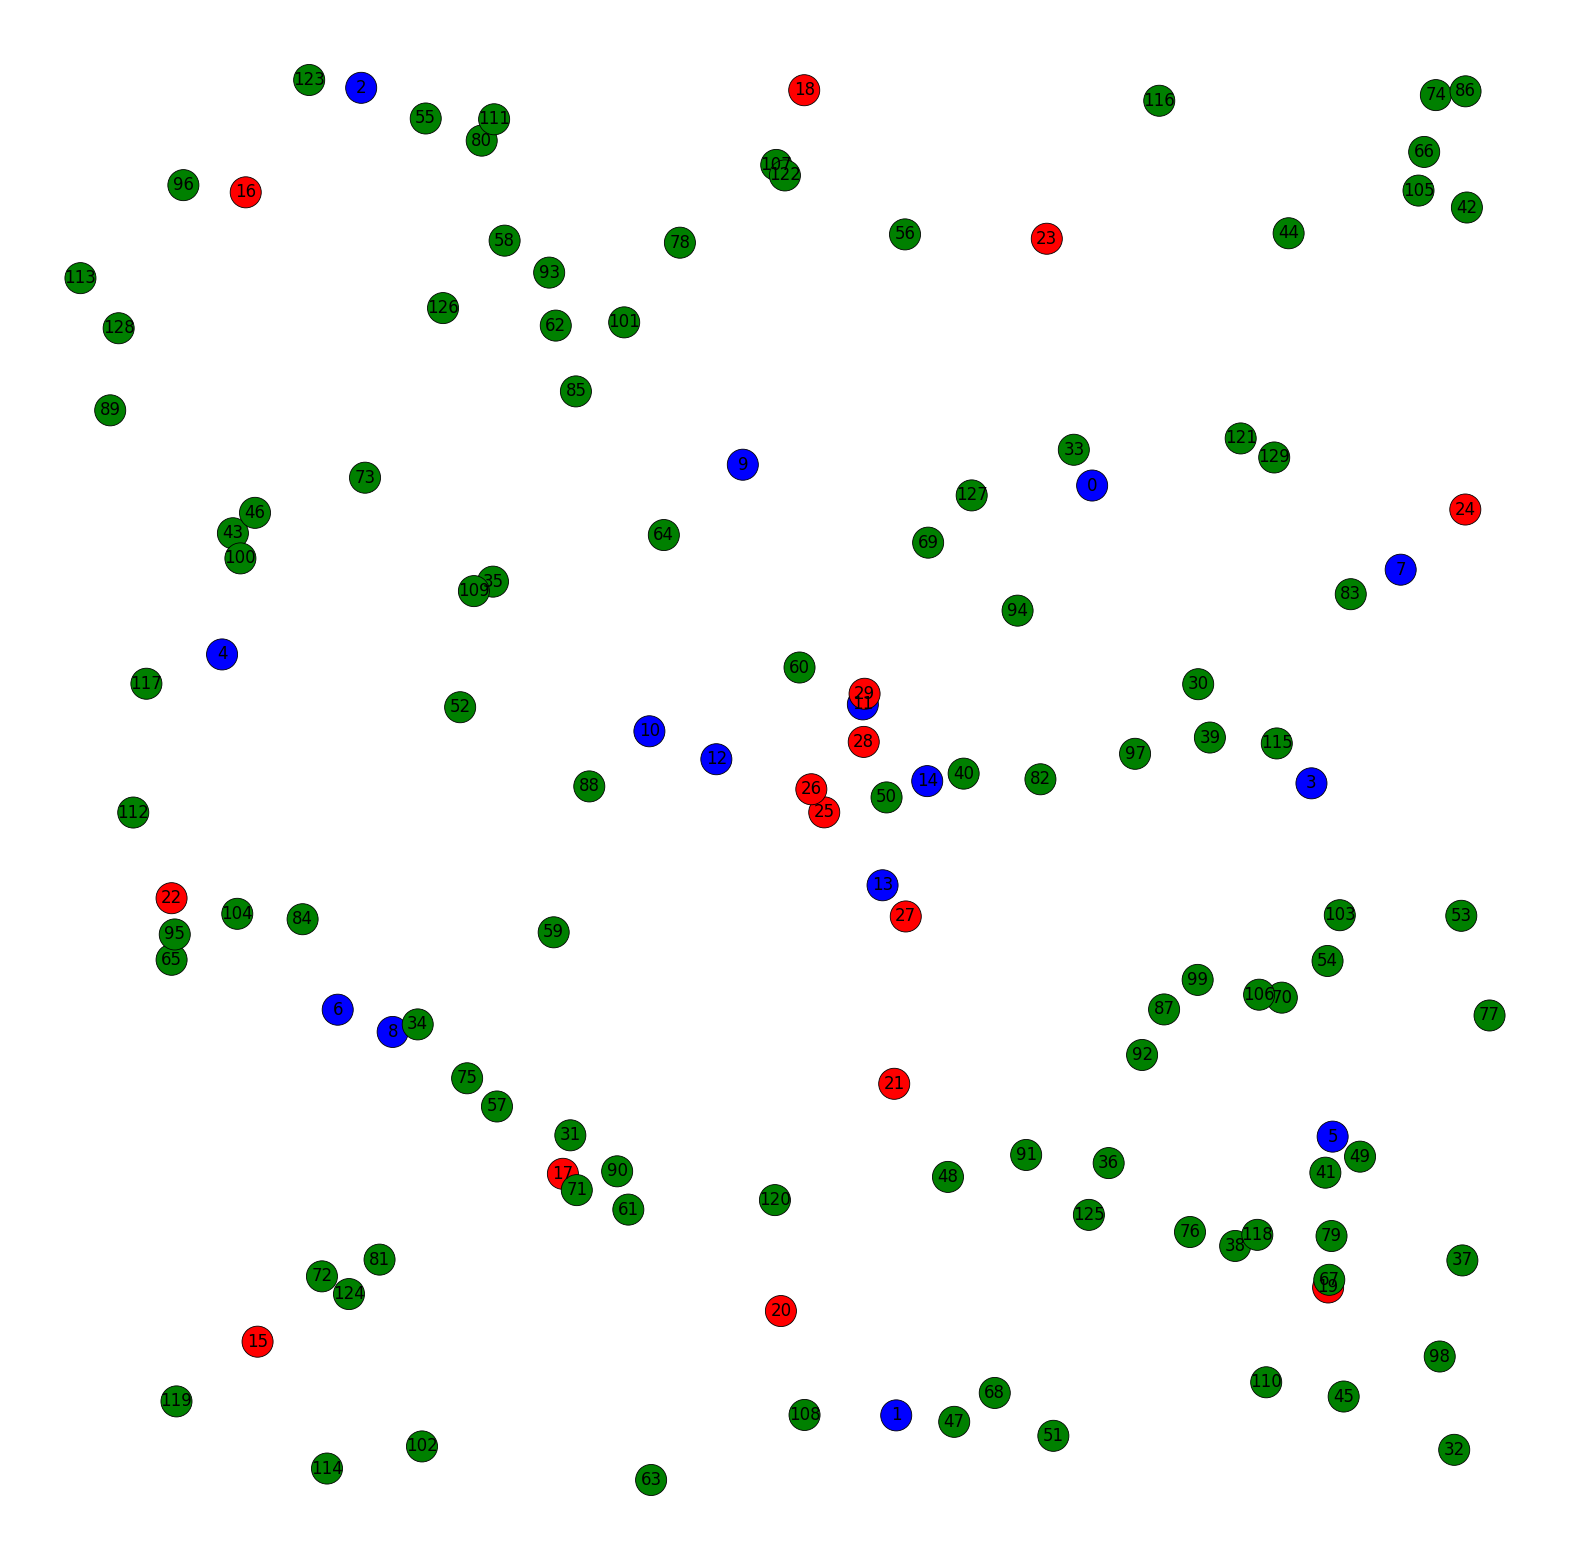

In [1762]:
DrawInitG(G,(graph_size,graph_size), withedges=False)

## Optimizing the model

In [1763]:
#Creating the model
pcf = gb.Model('Primary care facility')

In [1764]:
# je crois que c'est bon maintenant
# Variable decision x1, x1[k] = 1 if clinic k is established
x1 = pcf.addVars(index_of_clinic,vtype=gb.GRB.BINARY, name='x1')
# Variable decision x2, x2[j] = 1 if hospital j is established
x2 = pcf.addVars(index_of_hospitals,vtype=gb.GRB.BINARY, name='x2')
# Variable decision u, u[i][k] = number of patient who go to node i to clinic k
u = pcf.addVars([(i,k) for i in index_of_demand_points for k in index_of_clinic],
                # we have to precise the index range of u, if not it will not compute because gurobi is lost with the index
                lb = 0, # lower bound (u_ik >= 0)
                obj=[G.edges[(i,k)]['dist'] for i in index_of_demand_points for k in index_of_clinic], 
                vtype=gb.GRB.INTEGER, name='u')
# Variable decision v, v[k][j] = number of patient who go to clinic k to hospital j
v = pcf.addVars([(k,j) for k in index_of_clinic for j in index_of_hospitals],
                lb = 0, 
                obj=[G[k][j]['dist'] for k in index_of_clinic for j in index_of_hospitals], 
                vtype=gb.GRB.INTEGER, name='v')
pcf.update()
pcf.write('pcf.lp')


In [1765]:
0.78 * 7

5.46

In [1766]:
round(0.78 * 7)

5

In [1767]:
theta[0]*u.sum('*',0)

<gurobi.LinExpr: 0.64 u[30,0] + 0.64 u[31,0] + 0.64 u[32,0] + 0.64 u[33,0] + 0.64 u[34,0] + 0.64 u[35,0] + 0.64 u[36,0] + 0.64 u[37,0] + 0.64 u[38,0] + 0.64 u[39,0] + 0.64 u[40,0] + 0.64 u[41,0] + 0.64 u[42,0] + 0.64 u[43,0] + 0.64 u[44,0] + 0.64 u[45,0] + 0.64 u[46,0] + 0.64 u[47,0] + 0.64 u[48,0] + 0.64 u[49,0] + 0.64 u[50,0] + 0.64 u[51,0] + 0.64 u[52,0] + 0.64 u[53,0] + 0.64 u[54,0] + 0.64 u[55,0] + 0.64 u[56,0] + 0.64 u[57,0] + 0.64 u[58,0] + 0.64 u[59,0] + 0.64 u[60,0] + 0.64 u[61,0] + 0.64 u[62,0] + 0.64 u[63,0] + 0.64 u[64,0] + 0.64 u[65,0] + 0.64 u[66,0] + 0.64 u[67,0] + 0.64 u[68,0] + 0.64 u[69,0] + 0.64 u[70,0] + 0.64 u[71,0] + 0.64 u[72,0] + 0.64 u[73,0] + 0.64 u[74,0] + 0.64 u[75,0] + 0.64 u[76,0] + 0.64 u[77,0] + 0.64 u[78,0] + 0.64 u[79,0] + 0.64 u[80,0] + 0.64 u[81,0] + 0.64 u[82,0] + 0.64 u[83,0] + 0.64 u[84,0] + 0.64 u[85,0] + 0.64 u[86,0] + 0.64 u[87,0] + 0.64 u[88,0] + 0.64 u[89,0] + 0.64 u[90,0] + 0.64 u[91,0] + 0.64 u[92,0] + 0.64 u[93,0] + 0.64 u[94,0] + 0.64 u[9

### Constraints

In [1768]:
pcf.addConstrs((u.sum(i, '*') == C[i] for i in index_of_demand_points), name='29')
pcf.addConstrs((v.sum(k, '*') >= theta[k]*u.sum('*',k) for k in index_of_clinic), name='30')
# the constraint 30 is the main problem to unfeasible. To solve it I put an inequality instead of an equality

pcf.addConstrs((u.sum('*', k) <= C[k]*x1[k] for k in index_of_clinic), name='31')
pcf.addConstrs((v.sum('*', j) <= C[j]*x2[j] for j in index_of_hospitals), name='32')

pcf.addConstr(x1.sum('*') == p , name='33')
pcf.addConstr(x2.sum('*') == q , name='34')

pcf.update()
pcf.write('pcf.lp')

# Domain constraints useless before be can define it 

In [1769]:
totalcapacityclinic = 0
for k in index_of_clinic:
    totalcapacityclinic = totalcapacityclinic + C[k]
totalcapacityhospital = 0
for k in index_of_hospitals:
    totalcapacityhospital = totalcapacityhospital + C[k]
totaldemand = 0
for k in index_of_demand_points:
    totaldemand = totaldemand + C[k]
print(totalcapacityclinic)
print(totalcapacityhospital)
print(totaldemand)

3400
21500
1473


In [1770]:
pcf.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 147 rows, 1755 columns and 5010 nonzeros
Model fingerprint: 0xd062870f
Variable types: 0 continuous, 1755 integer (30 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+03]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 2e+01]
Presolve time: 0.00s
Presolved: 147 rows, 1755 columns, 5010 nonzeros
Variable types: 0 continuous, 1755 integer (30 binary)

Root relaxation: objective 6.491499e+03, 225 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6491.49947    0   23          - 6491.49947      -     -    0s
H    0     0         

In [1773]:
print('Obj: %g' % pcf.objVal)
print(pcf.getVars())
print ()

for y in pcf.getVars():
    if y.x > 1E-3:
        print ('%s=%g' % (y.varName, y.x), end = ' ')


x1[4]=1 x1[5]=1 x1[8]=1 x1[9]=1 x1[13]=1 x2[17]=1 x2[19]=1 x2[22]=1 x2[27]=1 x2[29]=1 u[30,13]=5 u[31,8]=20 u[32,5]=11 u[33,9]=24 u[34,8]=23 u[35,4]=12 u[36,5]=6 u[36,13]=15 u[37,5]=24 u[38,5]=8 u[39,13]=23 u[40,13]=18 u[41,5]=9 u[42,9]=14 u[43,4]=23 u[44,9]=7 u[45,5]=16 u[46,4]=23 u[47,13]=23 u[48,13]=14 u[49,5]=21 u[50,13]=17 u[51,5]=16 u[52,4]=24 u[53,5]=10 u[54,5]=6 u[55,4]=9 u[56,9]=14 u[57,8]=9 u[58,4]=20 u[59,8]=10 u[60,9]=10 u[60,13]=13 u[61,8]=23 u[62,9]=5 u[63,8]=20 u[64,9]=18 u[65,4]=24 u[66,9]=6 u[67,5]=19 u[68,13]=20 u[69,9]=24 u[70,5]=22 u[71,8]=11 u[72,8]=9 u[73,4]=18 u[74,9]=5 u[75,8]=10 u[76,5]=18 u[77,5]=5 u[78,9]=17 u[79,5]=11 u[80,4]=14 u[81,8]=20 u[82,13]=21 u[83,13]=14 u[84,8]=12 u[85,9]=14 u[86,9]=7 u[87,13]=7 u[88,8]=10 u[89,4]=6 u[90,8]=24 u[91,13]=11 u[92,13]=24 u[93,9]=7 u[94,13]=16 u[95,4]=14 u[96,4]=5 u[97,13]=17 u[98,5]=21 u[99,5]=16 u[100,4]=14 u[101,9]=18 u[102,8]=15 u[103,5]=15 u[104,4]=13 u[105,9]=17 u[106,5]=21 u[107,9]=10 u[108,8]=9 u[109,4]=16 u[11

In [1774]:
u

{(30, 0): <gurobi.Var u[30,0] (value -0.0)>,
 (30, 1): <gurobi.Var u[30,1] (value -0.0)>,
 (30, 2): <gurobi.Var u[30,2] (value -0.0)>,
 (30, 3): <gurobi.Var u[30,3] (value -0.0)>,
 (30, 4): <gurobi.Var u[30,4] (value -0.0)>,
 (30, 5): <gurobi.Var u[30,5] (value -0.0)>,
 (30, 6): <gurobi.Var u[30,6] (value -0.0)>,
 (30, 7): <gurobi.Var u[30,7] (value -0.0)>,
 (30, 8): <gurobi.Var u[30,8] (value -0.0)>,
 (30, 9): <gurobi.Var u[30,9] (value -0.0)>,
 (30, 10): <gurobi.Var u[30,10] (value -0.0)>,
 (30, 11): <gurobi.Var u[30,11] (value -0.0)>,
 (30, 12): <gurobi.Var u[30,12] (value -0.0)>,
 (30, 13): <gurobi.Var u[30,13] (value 5.0)>,
 (30, 14): <gurobi.Var u[30,14] (value -0.0)>,
 (31, 0): <gurobi.Var u[31,0] (value -0.0)>,
 (31, 1): <gurobi.Var u[31,1] (value -0.0)>,
 (31, 2): <gurobi.Var u[31,2] (value -0.0)>,
 (31, 3): <gurobi.Var u[31,3] (value -0.0)>,
 (31, 4): <gurobi.Var u[31,4] (value -0.0)>,
 (31, 5): <gurobi.Var u[31,5] (value -0.0)>,
 (31, 6): <gurobi.Var u[31,6] (value -0.0)>,
 

In [1775]:
v

{(0, 15): <gurobi.Var v[0,15] (value -0.0)>,
 (0, 16): <gurobi.Var v[0,16] (value -0.0)>,
 (0, 17): <gurobi.Var v[0,17] (value -0.0)>,
 (0, 18): <gurobi.Var v[0,18] (value -0.0)>,
 (0, 19): <gurobi.Var v[0,19] (value -0.0)>,
 (0, 20): <gurobi.Var v[0,20] (value -0.0)>,
 (0, 21): <gurobi.Var v[0,21] (value -0.0)>,
 (0, 22): <gurobi.Var v[0,22] (value -0.0)>,
 (0, 23): <gurobi.Var v[0,23] (value -0.0)>,
 (0, 24): <gurobi.Var v[0,24] (value -0.0)>,
 (0, 25): <gurobi.Var v[0,25] (value -0.0)>,
 (0, 26): <gurobi.Var v[0,26] (value -0.0)>,
 (0, 27): <gurobi.Var v[0,27] (value -0.0)>,
 (0, 28): <gurobi.Var v[0,28] (value -0.0)>,
 (0, 29): <gurobi.Var v[0,29] (value -0.0)>,
 (1, 15): <gurobi.Var v[1,15] (value -0.0)>,
 (1, 16): <gurobi.Var v[1,16] (value -0.0)>,
 (1, 17): <gurobi.Var v[1,17] (value -0.0)>,
 (1, 18): <gurobi.Var v[1,18] (value -0.0)>,
 (1, 19): <gurobi.Var v[1,19] (value -0.0)>,
 (1, 20): <gurobi.Var v[1,20] (value -0.0)>,
 (1, 21): <gurobi.Var v[1,21] (value -0.0)>,
 (1, 22): 

In [1776]:
# Creating xfinal, the dict of all active edges

xfinal = dict(u)
xfinal.update(v)
# Removing the key from the dict if the value is 0, e.G the edge isn't active
for xtuple in list(xfinal) :
    # print(xfinal[xtuple])
    # print(xfinal[xtuple].x)
    # print(xtuple)
    if xfinal[xtuple].x == 0 :
        xfinal.pop(xtuple, None)

<gurobi.Var u[30,0] (value -0.0)>
-0.0
(30, 0)
<gurobi.Var u[30,1] (value -0.0)>
-0.0
(30, 1)
<gurobi.Var u[30,2] (value -0.0)>
-0.0
(30, 2)
<gurobi.Var u[30,3] (value -0.0)>
-0.0
(30, 3)
<gurobi.Var u[30,4] (value -0.0)>
-0.0
(30, 4)
<gurobi.Var u[30,5] (value -0.0)>
-0.0
(30, 5)
<gurobi.Var u[30,6] (value -0.0)>
-0.0
(30, 6)
<gurobi.Var u[30,7] (value -0.0)>
-0.0
(30, 7)
<gurobi.Var u[30,8] (value -0.0)>
-0.0
(30, 8)
<gurobi.Var u[30,9] (value -0.0)>
-0.0
(30, 9)
<gurobi.Var u[30,10] (value -0.0)>
-0.0
(30, 10)
<gurobi.Var u[30,11] (value -0.0)>
-0.0
(30, 11)
<gurobi.Var u[30,12] (value -0.0)>
-0.0
(30, 12)
<gurobi.Var u[30,13] (value 5.0)>
5.0
(30, 13)
<gurobi.Var u[30,14] (value -0.0)>
-0.0
(30, 14)
<gurobi.Var u[31,0] (value -0.0)>
-0.0
(31, 0)
<gurobi.Var u[31,1] (value -0.0)>
-0.0
(31, 1)
<gurobi.Var u[31,2] (value -0.0)>
-0.0
(31, 2)
<gurobi.Var u[31,3] (value -0.0)>
-0.0
(31, 3)
<gurobi.Var u[31,4] (value -0.0)>
-0.0
(31, 4)
<gurobi.Var u[31,5] (value -0.0)>
-0.0
(31, 5)
<guro

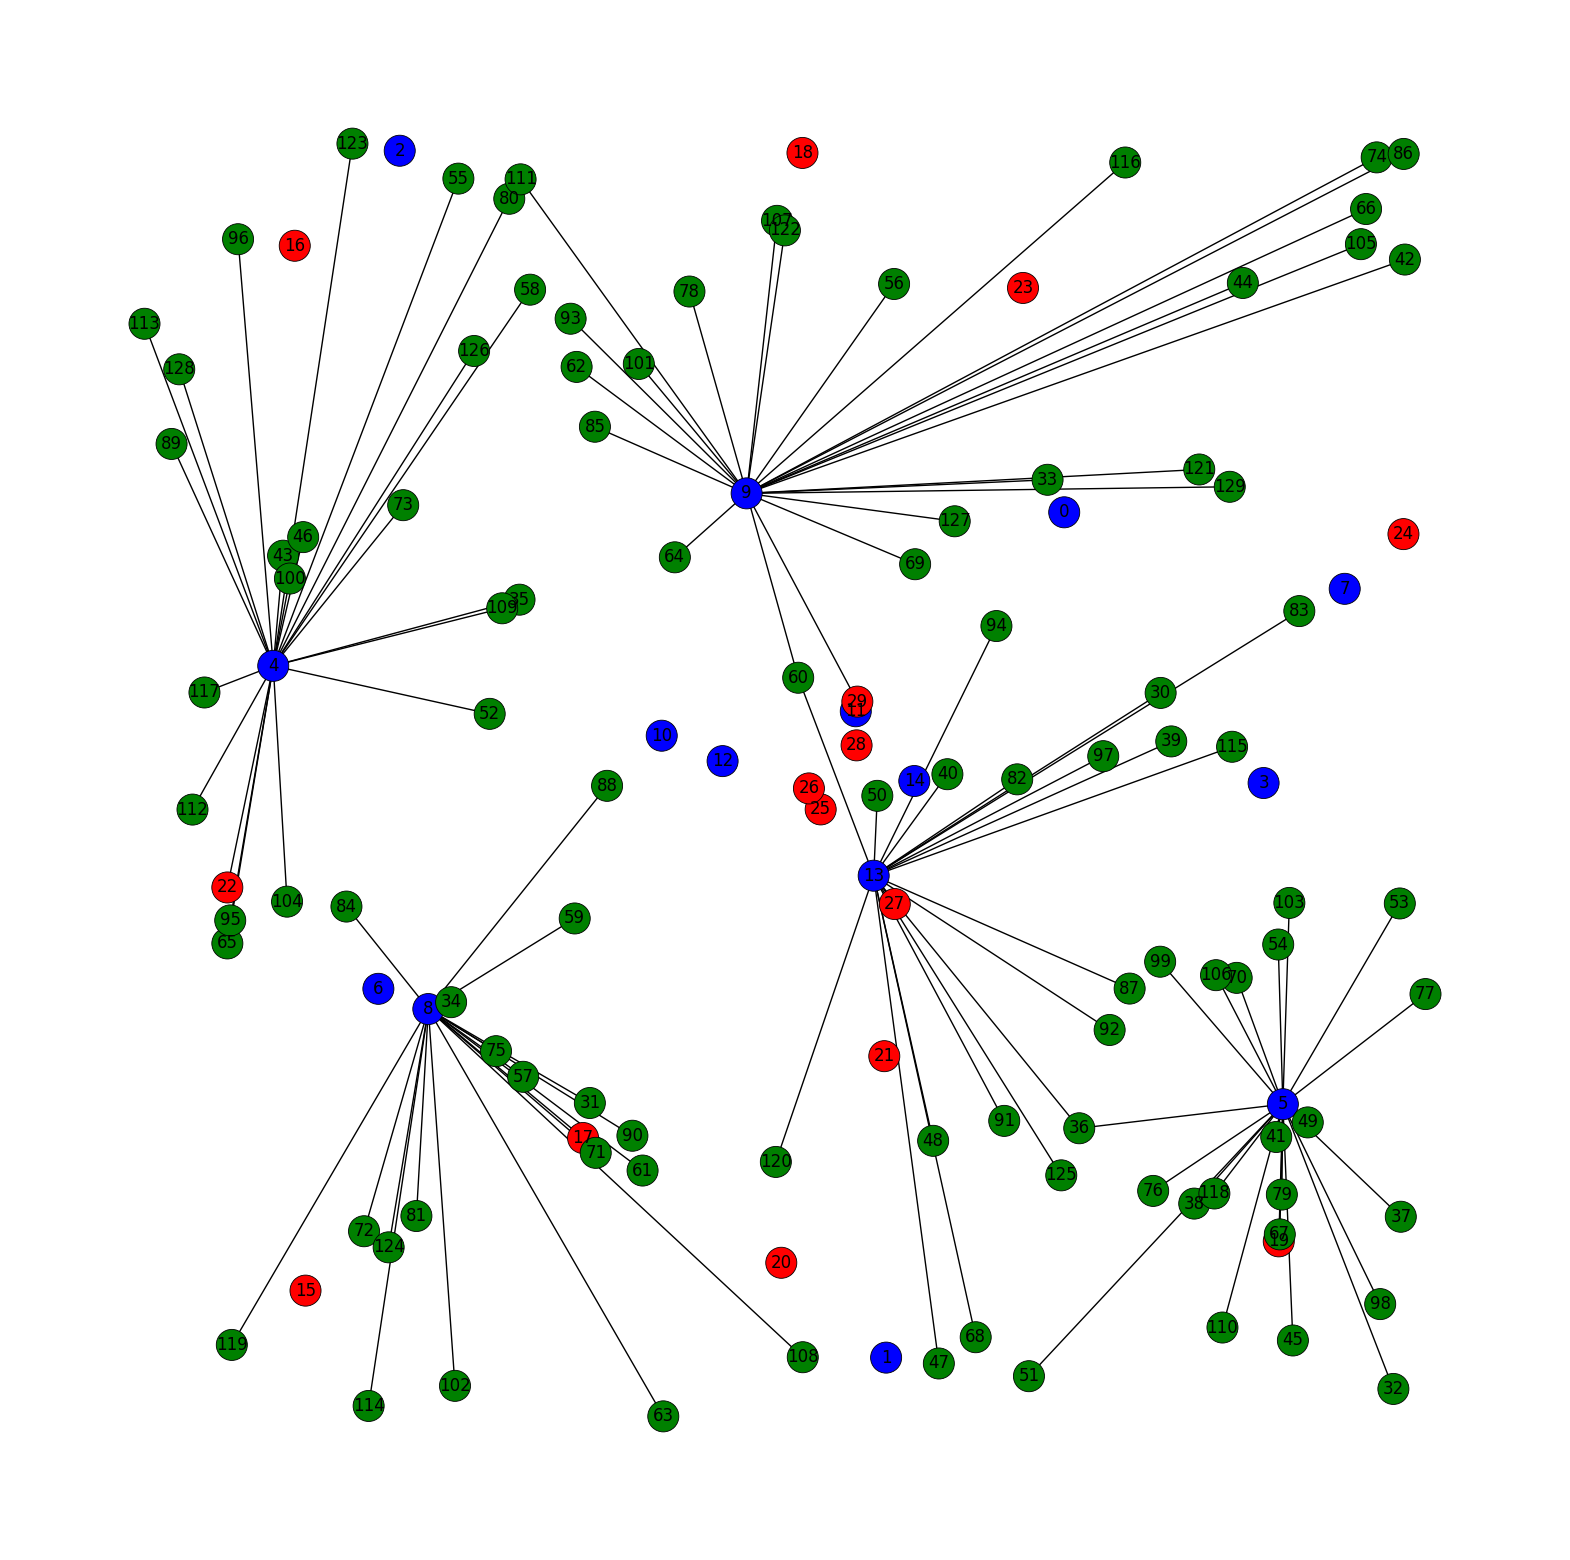

In [1777]:
DrawSol(G, (graph_size,graph_size), xfinal)

### Compared with real data


Position of clinics in the city of Nantes, France


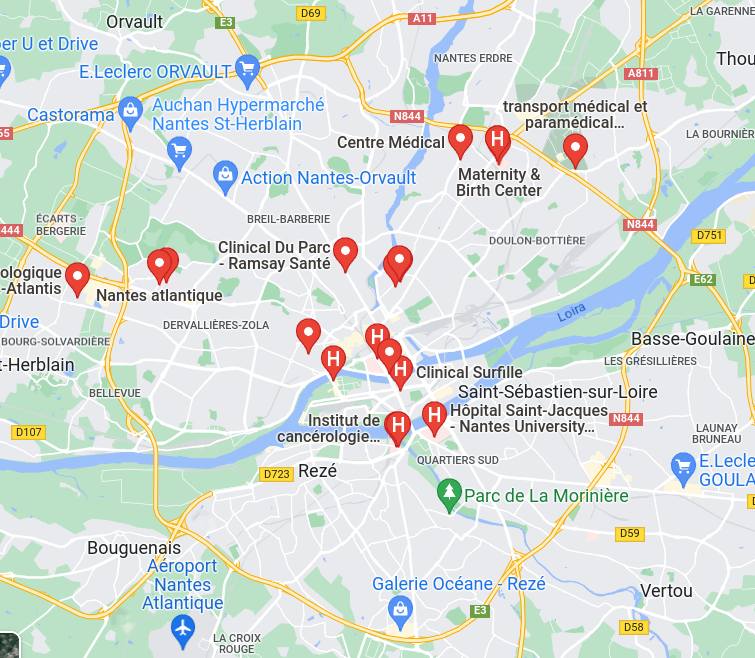

Position of hospital in the city of Nantes, France

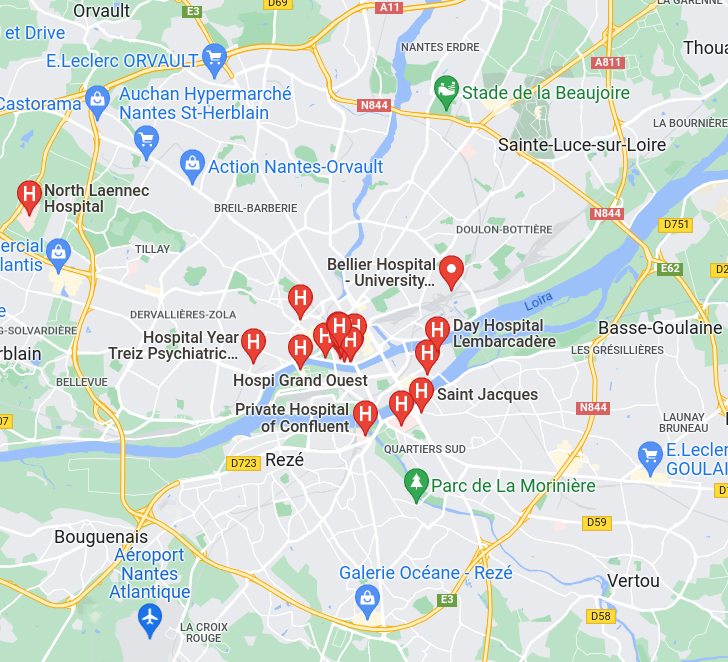